## Import modules and load GPS data 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DayLocator, DateFormatter, HourLocator
plt.style.use("project.mplstyle")

import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np
from dateparser import parse
import cmcrameri.cm as cmc
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
from matplotlib.dates import DayLocator,DateFormatter,HourLocator
import gsw
import cartopy.io.img_tiles as cimgt
from tools import plot_scale_bar
from matplotlib.gridspec import GridSpec

proj = ccrs.PlateCarree()

ERROR 1: PROJ: proj_create_from_database: Open of /autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/coringa/share/proj failed


In [60]:
colors = dict(
    land = "#ddd3aaff",
    coastline = "#02a8d5ff",
    ocean = ["#6fadd6ff", "#83b8ddff", "#a9cdeaff", "#b0d5f1ff", "#c9e1f5ff"],
)

def map_layout(ax, extent = [-66, -34, -7, 15], add_colorbar = False, colors = colors):
    ax.set_extent([-66, -33, -7, 15], crs=ccrs.PlateCarree())

    levels = -np.array([0, 150, 1500, 3000, 4000, 8000])
    kw = dict(
        x = "lon", y = "lat",
        levels = np.array([-6000, -4000, -3000, -1500, -150, 0]),
        colors = colors["ocean"],
        transform = ccrs.PlateCarree(),
        extend = "neither", zorder = 0,
        add_colorbar = add_colorbar,
    )
    C = bat.plot.contourf(ax = ax, **kw)

    ax.add_feature(cfeature.LAND, facecolor = colors["land"], zorder = 1)
    ax.add_feature(cfeature.OCEAN, facecolor = colors["ocean"][-1], zorder = -1)
    ax.add_feature(cfeature.COASTLINE, color = colors["coastline"])
    ax.add_feature(cfeature.BORDERS, linestyle='-', color = "0.3", lw = 0.6)
    ax.add_feature(cfeature.STATES, linestyle=':', facecolor = "none", edgecolor = "0.5", lw = 0.6)
    ax.add_feature(cfeature.LAKES, alpha=0.5, color = colors["coastline"])
    ax.add_feature(cfeature.RIVERS, color = colors["coastline"], alpha = 0.3)
    
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    return C

In [56]:
# Load the bathymetry dataset
bat = xr.open_dataset("../data/gebco_2022_n21.4673_s-7.4048_w-68.6426_e-32.7393.nc").elevation
# Select specific latitude and longitude slices
bat = bat.sel(lat=slice(-7.5, 15, 10), lon=slice(-66, -30, 10))

# load data
df = pd.read_csv("../data/planilhaSateliteTicoR4.csv", delimiter=";")
df = df.rename(columns={"Classe Argos":"Class"})
df = df[~df["Class"].apply(lambda c: ("Uncertain" in c)|("Unresolved" in c))]

# parse timestamps
time = (df["Data"]+" "+df["Hora"]).apply(parse)

# set index
df = df[["Longitude","Latitude","Class"]]
df.index = time
df.index.name = "time"

ds = df.to_xarray()
ds = ds.assign(x = 111.32e3 * np.cos(np.deg2rad(ds.Latitude)) * ds.Longitude,y = 110.574e3 * ds.Latitude)
ds = ds.assign(x = ds.x-ds.x.isel(time=0), y = ds.y-ds.y.isel(time=0))
ds = ds.sortby("time")

ds = ds.rename(Longitude="longitude",Latitude="latitude")

Plotting positions separated by each ARGO class.

Error estimates:
 - **G (GPS):** 5 m
 - **Q / QFP (GPS corrected):** 5 to 500 m
 - **3 (Argos):** < 250 m
 - **2 (Argos):** 250 to 500 m
 - **1 (Argos):** 500 to 1500 m
 - **0 (Argos):** > 1500 m

/autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/coringa/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


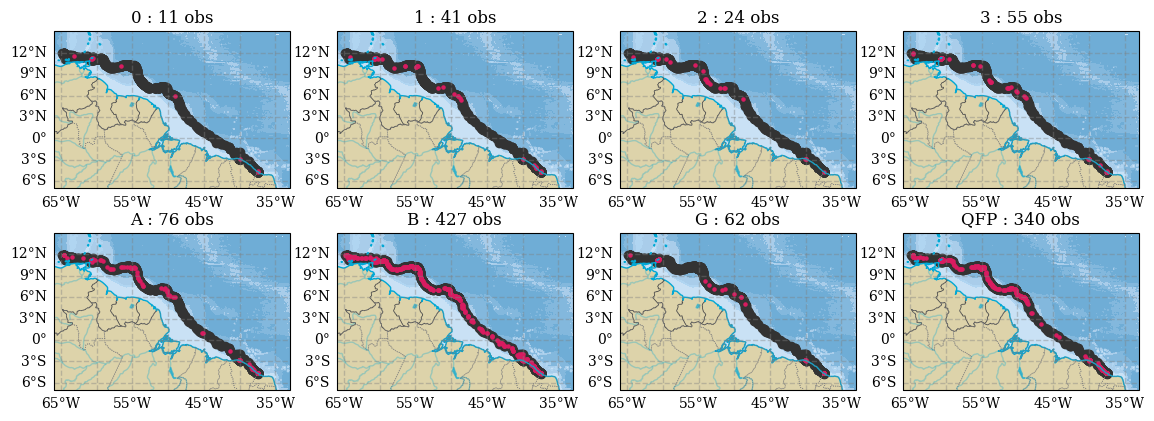

In [63]:
classes = np.unique(ds.Class)
fig,ax = plt.subplots(2, classes.size//2, figsize=(14,4.8), subplot_kw=dict(projection=proj))

ax = np.ravel(ax)
for i,c in enumerate(classes):
    map_layout(ax[i])
    
    ds.plot.scatter(x="longitude",y="latitude", ax=ax[i], color="0.2", transform=proj,edgecolor=None)
    ds.where(ds.Class==c).plot.scatter(x="longitude",y="latitude", ax=ax[i], color="#D81B60", s=5,edgecolor=None)
    ax[i].set(title=f"{c} : {(ds.Class==c).sum().values} obs", xlabel="", ylabel="")
fig.savefig("../img/Argo_classes.png", dpi=300)

In [58]:
plt.figure(); p = bat.plot.contour(x = "lon", y = "lat", levels = [0]); plt.close();
px, py = np.vstack([np.vstack(segs) for segs in p.allsegs]).T
px, py = xr.DataArray(px, dims = ["obs"]), xr.DataArray(py, dims = ["obs"])

lat2km = 111.195 # 1 deg lat = 111.195 km
lon2km = lat2km*np.cos(py*np.pi/180) # 1 deg lon = 111.195*cos(lat) km
ds = ds.assign(distance = np.sqrt((lon2km * (ds.longitude - px))**2 + (lat2km * (ds.latitude - py))**2).min("obs"))

/tmp/ipykernel_3309567/3996583664.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(C, cax = cax, orientation = "horizontal")
/autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/coringa/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)
/autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/coringa/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


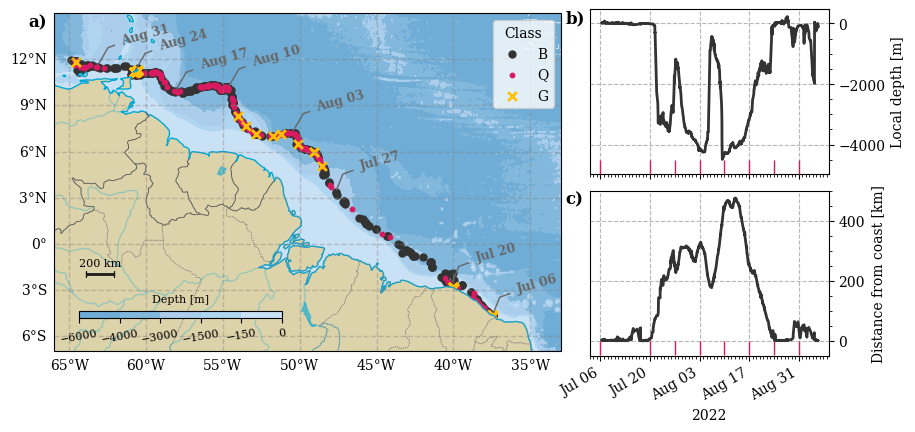

In [64]:
dates = ["2022-07-06","2022-07-20", "2022-07-27", "2022-08-03", "2022-08-10", "2022-08-17","2022-08-24", "2022-08-31"]
dsi = ds.interp(time = [np.datetime64(f"{s} 11:00") for s in dates], method = "nearest")
dsi = dsi.assign_coords(time = dsi.time.dt.round("D"))


fig = plt.figure(figsize = (10, 4.5))
gs = GridSpec(2, 3, figure=fig)
ax = fig.add_subplot(gs[:, :2], projection=ccrs.PlateCarree())
ax1 = fig.add_subplot(gs[0, -1])
ax2 = fig.add_subplot(gs[1, -1])

fig.subplots_adjust(wspace = 0.12, hspace = 0.1)

C = map_layout(ax)

cax = ax.inset_axes([0.05, 0.1, 0.4, 0.02]) 
fig.colorbar(C, cax = cax, orientation = "horizontal")
cax.set_title("Depth [m]", fontsize = 8)
cax.tick_params(axis = 'both', which = 'major', labelsize = 8, rotation = 10)

ds.where(ds.Class=="B").plot.scatter(x="longitude", y="latitude", ax=ax, color="0.2", s=25, edgecolor=None, zorder = 0, label = "B")
ds.where(ds.Class=="QFP").plot.scatter(x="longitude", y="latitude", ax=ax, color="#D81B60", s=10, edgecolor=None, zorder = 0, label = "Q")
ds.where(ds.Class=="G").plot.scatter(x="longitude", y="latitude", ax=ax, marker = "x", color="#FFC107", s=40, zorder = 0, label = "G")

ax.legend(loc = 1, title = "Class")


lon, lat, time = dsi.longitude.values, dsi.latitude.values, dsi.time.values

for loni, lati, timei in zip(lon, lat, time):                    
    text = pd.to_datetime(str(timei.astype('datetime64[D]'))).strftime('%b %d')
    ax.annotate(
        text,
        xy=(loni, lati), xycoords='data',
        xytext=(loni + 1.5, lati + 1.5), textcoords='data',
        arrowprops=dict(color = "0.4", arrowstyle="-",connectionstyle="arc,angleA=20,armA=-40,rad=0"),
        color = "0.4", weight = "bold", size = 9, rotation = 15
    )
    
plot_scale_bar(ax, 200, -63, -2, orientation = "horizontal")


bat.interp(lon = ds.longitude, lat = ds.latitude).plot(ax = ax1, color = "0.2")
ds.distance.plot(ax = ax2, color = "0.2")

fmt = "%b %d"
for a in [ax1, ax2]:
    ylim = a.get_ylim()
    a.plot(time,[ylim[0]]*time.size,
           marker="|",lw=0,color="#D81B60",
           clip_on=False,zorder=1e4, markersize=10,
    )
    a.yaxis.set_label_position("right")
    a.yaxis.tick_right()
    a.xaxis.set_minor_locator(DayLocator(interval=1))
    a.xaxis.set_major_locator(DayLocator(interval=14))
    a.xaxis.set_major_formatter(DateFormatter(fmt))
ax1.set(xticklabels = [], ylabel = "Local depth [m]", xlabel = "");
ax2.set(ylabel = "Distance from coast [km]", xlabel = "2022");


ax.text(-0.05, 1, "a)", transform=ax.transAxes,
  fontsize=12, fontweight='bold', va='top', ha='left')

for a, label in zip([ax1, ax2], "b) c)".split()):
    a.text(-0.1, 1, label, transform=a.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='left')
    
fig.savefig("../img/map.png", dpi=300, bbox_inches = "tight", facecolor = "w")

Let's retain the QFP and G positions, as they are the most accurate. However, a segment of the trajectory is predominantly covered by B. While we acknowledge that we cannot estimate the error for the B positions, they appear to follow the same path as the more accurate positions. Therefore, we should keep B but also filter the data to eliminate any spurious positions.

In [65]:
argo_classes = ["QFP","G","B"]
ds = ds.where(ds.Class.isin(argo_classes), drop=True)

Most of the data is around 1h resolution

(array([141., 273., 119.,  55.,  27.,  31.,  10.,  12.,  10.,   8.,   7.,
          9.,   7.,   7.,   1.,   7.,   5.,   3.,   3.,   2.,   2.,   2.,
          0.,   2.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,
         4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
         9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
        13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75,
        18.25, 18.75, 19.25, 19.75]),
 <BarContainer object of 39 artists>)

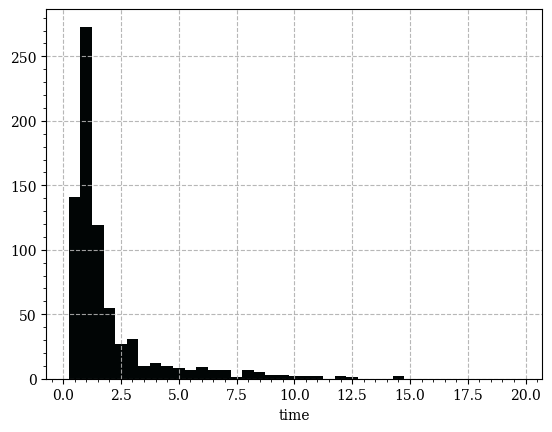

In [66]:
(ds.time.diff("time").astype("float")*1e-9/3600).plot.hist(bins=np.arange(0.25,20.25,0.5))

So, lets interpolate it 1h.

In [67]:
freq = "1H"
tmin = ds.time.min().dt.strftime("%Y-%m-%d %H:%M").values.tolist()
tmax = ds.time.max().dt.strftime("%Y-%m-%d %H:%M").values.tolist()
ds0 = ds.interp(time=pd.date_range(start=tmin,end=tmax,freq=freq))[["longitude","latitude","x","y"]]

We apply a 2-day hanning filter to smooth the data. Specifically, Tico's position at any given time will be substituted by a weighted average spanning from 24 hours prior to 24 hours post that time. This weighting is maximized at the center and tapers to zero at both ends.

In [68]:
window = 2*24+1 # hours
weight = xr.DataArray(np.hanning(window), dims=['window'])
smooth = lambda ds: ds.rolling(time=window,center=True,min_periods=1).construct('window').dot(weight)/weight.sum()

In [69]:
dsi = ds0.assign({k:smooth(ds0[k]) for k in list(ds0)})
dsi = dsi.assign(u = dsi.x.differentiate("time", datetime_unit="s"), v = dsi.y.differentiate("time", datetime_unit="s"))
dsi = dsi.assign(spd = np.sqrt(dsi.u**2 + dsi.v**2))
dsi = dsi.dropna("time")

ds0 = ds0.assign(u = ds0.x.differentiate("time", datetime_unit="s"), v = ds0.y.differentiate("time", datetime_unit="s"))
ds0 = ds0.assign(spd = np.sqrt(ds0.u**2 + ds0.v**2))
ds0 = ds0.dropna("time")

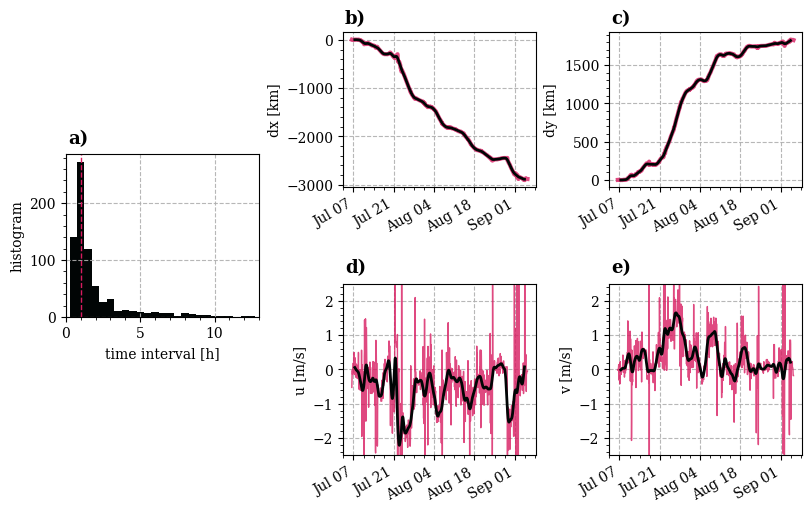

In [70]:
fmt = "%b %d"

fig = plt.figure(layout="constrained", figsize=(8,5))
ax = fig.subplot_mosaic(
    [
        [".",".",1,1,3,3],
        [0,0,1,1,3,3],
        [0,0,2,2,4,4],
        [".",".",2,2,4,4],
    ]
)


(ds.time.diff("time").astype("float")*1e-9/3600).plot.hist(ax=ax[0],bins=np.arange(0.25,20.25,0.5))
ax[0].axvline(1,linestyle="--",color="#D81B60",lw=1)
ax[0].set(xlim=[0,13],ylabel="histogram",xlabel="time interval [h]")

(dsi.x*1e-3).plot(ax=ax[1],zorder=1e3)
(ds0.x*1e-3).plot(ax=ax[1],lw=3, alpha = 0.8)

(dsi.u).plot(ax=ax[2],zorder=1e3)
(ds0.u).plot(ax=ax[2],lw=1., alpha = 0.8)

(dsi.y*1e-3).plot(ax=ax[3],zorder=1e3)
(ds0.y*1e-3).plot(ax=ax[3],lw=3, alpha = 0.8)

(dsi.v).plot(ax=ax[4],zorder=1e3)
(ds0.v).plot(ax=ax[4],lw=1., alpha = 0.8)

ax[1].set(ylabel="dx [km]",xlabel="")
ax[3].set(ylabel="dy [km]",xlabel="")

ax[2].set(ylabel="u [m/s]",xlabel="")
ax[4].set(ylabel="v [m/s]",xlabel="")

for a in [ax[2],ax[4]]:
    a.set(ylim=[-2.5,2.5])
    
for k in range(1,5):
    a = ax[k]
    a.xaxis.set_major_locator(DayLocator(interval=14))
    a.xaxis.set_major_formatter(DateFormatter(fmt))
    
for k, label in zip(range(5),"a) b) d) c) e)".split()):
    a = ax[k]
    a.text(0.01, 1.15, label, transform=a.transAxes,
      fontsize=13, fontweight='bold', va='top', ha='left')
    
fig.savefig("../img/filtering.png", dpi=300, bbox_inches = "tight", facecolor = "w")

In [71]:
gsw.distance(dsi.longitude.values[[0,-1]],dsi.latitude.values[[0,-1]]).sum()*1e-3

3524.660938039011

In [72]:
gsw.distance(dsi.longitude.values,dsi.latitude.values).sum()*1e-3

4021.553800554036

In [73]:
(dsi.time.max()-dsi.time.min()).values*1e-9/86400

numpy.timedelta64(58,'ns')

In [74]:
# Define the attributes for each variable
attributes = {
    "longitude": {"long_name": "Longitude", "units": "degrees_east"},
    "latitude": {"long_name": "Latitude", "units": "degrees_north"},
    "x": {"long_name": "x position", "units": "m"},
    "y": {"long_name": "y position", "units": "m"},
    "u": {"long_name": "eastward component of velocity", "units": "m s-1"},
    "v": {"long_name": "northward component of velocity", "units": "m s-1"},
    "spd": {"long_name": "velocity magnitude", "units": "m s-1"},
}

# Apply the attributes to each variable in the dataset
for var, attrs in attributes.items():
    dsi[var].attrs.update(attrs)
    
# Add overall metadata about the dataset
dsi.attrs['creator'] = "Iury Simoes-Sousa"
dsi.attrs['email'] = "iuryt@pm.me"
dsi.attrs['creation_date'] = datetime.now().strftime('%Y-%m-%d')
dsi.attrs['description'] = ("This dataset is from telemetry data installed in an "
                            "Antillean manatee named Tico, rehabilitated by the AQUASIS team.")
dsi.attrs['argo_classes_retained'] = argo_classes
dsi.attrs['data_interpolation'] = (f"Data has been interpolated to have equidistant time intervals of {freq}.")
dsi.attrs['filter_applied'] = f"A hanning filter with a centered window of {window}H has been applied."
dsi.attrs['hanning_window'] = window
dsi.attrs['time_interval'] = freq

dsi

<xarray.Dataset>
Dimensions:    (time: 1415)
Coordinates:
  * time       (time) datetime64[ns] 2022-07-07T11:11:00 ... 2022-09-04T09:11:00
Data variables:
    longitude  (time) float64 -37.43 -37.43 -37.43 ... -64.66 -64.66 -64.66
    latitude   (time) float64 -4.665 -4.665 -4.665 -4.665 ... 11.8 11.81 11.82
    x          (time) float64 2.805e+03 2.998e+03 ... -2.889e+06 -2.889e+06
    y          (time) float64 -1.253e+03 -1.291e+03 ... 1.82e+06 1.821e+06
    u          (time) float64 0.0556 0.05102 0.04569 ... 0.02034 0.04866 0.07419
    v          (time) float64 -0.01247 -0.008888 -0.005021 ... 0.2222 0.2108
    spd        (time) float64 0.05698 0.05179 0.04596 ... 0.2344 0.2275 0.2235
Attributes:
    creator:                Iury Simoes-Sousa
    email:                  iuryt@pm.me
    creation_date:          2023-10-19
    description:            This dataset is from telemetry data installed in ...
    argo_classes_retained:  ['QFP', 'G', 'B']
    data_interpolation:     Data has been interpolated to have equidistant ti...
    filter_applied:         A hanning filter with a centered window of 49H ha...
    hanning_window:         49
    time_interval:          1H

In [18]:
dsi.to_pandas().to_csv("../data/tico_data_filtered.csv")

In [19]:
dsi.to_netcdf("../data/tico_data_filtered.nc")